<a href="https://colab.research.google.com/github/fiaazwa/DeepLearning/blob/main/DeepLearningTugas3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ✅ 1. Import Library
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
import os
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random

# Google Drive (Colab only)
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# ✅ 2. Path Dataset dan CSV (ganti sesuai drive kamu)
csv_path = "/content/drive/MyDrive/Tugas3_DeepLearning/traindataset_Rofiah_050.csv"
img_folder = "/content/drive/MyDrive/Tugas3_DeepLearning/DatasetMultilabel_Rofiah_050"
df = pd.read_csv(csv_path)
class_names = df.columns[1:].tolist()
print(df.head())

              id   sendok   gelas   garpu   piring
0  Gambar001.jpg        1       1       1        1
1  Gambar002.jpg        1       1       1        1
2  Gambar003.jpg        1       1       1        1
3  Gambar004.jpg        1       1       1        1
4  Gambar005.jpg        1       1       1        1


In [3]:
class CustomDataset(Dataset):
    def __init__(self, df, img_dir, transform=None): # Changed csv_file to df
        self.data = df.reset_index(drop=True) # Reset index to avoid issues
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.loc[idx, 'id'])
        image = Image.open(img_name).convert('RGB')
        labels = self.data.iloc[idx, 1:].astype(float).values # Excluding 'id' column
        labels = torch.tensor(labels, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, labels

In [4]:
# ✅ 4. Transformasi & split dataset
from torchvision import transforms

# Transformasi untuk data latih (train)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                          # Resize ke ukuran tetap
    transforms.RandomHorizontalFlip(p=0.5),                 # Flip acak untuk augmentasi
    transforms.RandomRotation(degrees=10),                  # Rotasi acak ±10°
    transforms.ColorJitter(brightness=0.2, contrast=0.2,
                           saturation=0.2, hue=0.1),        # Ubah warna acak
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),    # Crop acak (zoom kecil)
    transforms.ToTensor(),                                  # Konversi ke tensor
    transforms.Normalize([0.485, 0.456, 0.406],             # Normalisasi warna
                         [0.229, 0.224, 0.225])
])

# Transformasi untuk data validasi dan test (tidak perlu augmentasi)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),                          # Resize tetap
    transforms.ToTensor(),                                  # Konversi ke tensor
    transforms.Normalize([0.485, 0.456, 0.406],             # Sama normalisasi seperti train
                         [0.229, 0.224, 0.225])
])

#  Split dataframe jadi train, val, test
train_size = int(0.8 * len(df))
val_size = int(0.1 * len(df))
test_size = len(df) - train_size - val_size

train_df, val_df, test_df = torch.utils.data.random_split(df, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Buat dataset berdasarkan transformasi
train_dataset = CustomDataset(train_df.dataset.iloc[train_df.indices], img_folder, transform=train_transform)
val_dataset = CustomDataset(val_df.dataset.iloc[val_df.indices], img_folder, transform=val_transform)
test_dataset = CustomDataset(test_df.dataset.iloc[test_df.indices], img_folder, transform=val_transform)

# Buat DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


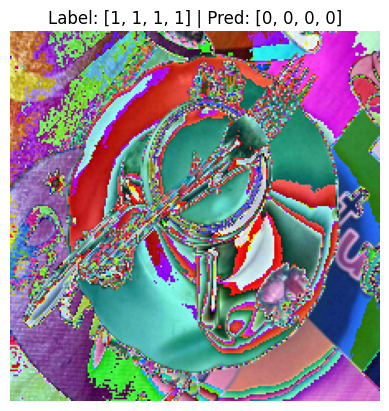

In [6]:
# ✅ 5. Sanity Check (Sebelum Training)
import matplotlib.pyplot as plt

num_classes = len(class_names)
model_sanity = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * 224 * 224, 512),  # Changed input features to match the image size
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(512, num_classes)
)

model_sanity.eval()

for images, labels in test_loader:
    image = images[0].unsqueeze(0)
    label = labels[0]
    output = model_sanity(image)
    pred = (output > 0.5).int().squeeze().tolist()

    plt.imshow(transforms.ToPILImage()(image.squeeze()))
    plt.title(f"Label: {label.int().tolist()} | Pred: {pred}")
    plt.axis("off")
    plt.show()
    break  # tampilkan 1 saja

In [8]:
# ✅ 6. CNN Model
class CustomCNN(nn.Module): # Added class definition

    def __init__(self, num_classes=4):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
          nn.Conv2d(3, 32, 3, padding=1),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.MaxPool2d(2),

          nn.Conv2d(32, 64, 3, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(2),

          nn.Conv2d(64, 128, 3, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.MaxPool2d(2),

          nn.Conv2d(128, 256, 3, padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.MaxPool2d(2),

          nn.AdaptiveAvgPool2d((4, 4))  # << TAMBAHKAN INI
      )


        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
          )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [9]:
# ✅ 7. Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN(num_classes=4).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [10]:
# ✅ 8. Training Loop + Early Stopping
num_epochs = 20
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_model_wts = copy.deepcopy(model.state_dict())
best_loss = float('inf')
patience = 5
counter = 0

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
            loader = train_loader
        else:
            model.eval()
            loader = val_loader

        running_loss = 0.0
        running_correct = 0
        total = 0

        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            preds = (torch.sigmoid(outputs) > 0.5).float()
            running_correct += (preds == labels).float().mean().item() * inputs.size(0)
            running_loss += loss.item() * inputs.size(0)
            total += inputs.size(0)

        epoch_loss = running_loss / total
        epoch_acc = running_correct / total

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)
            scheduler.step()  # Pindah ke akhir fase training
        else:
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc)

            if epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print("Early stopping.")
                    model.load_state_dict(best_model_wts)
                    break

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Cetak hasil tiap epoch (pastikan tidak error saat akses list kosong)
    if train_losses and val_losses:
        print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Acc={train_accuracies[-1]:.2f} | Val Loss={val_losses[-1]:.4f}, Acc={val_accuracies[-1]:.2f}")
    print("\n")

# Load best model
# model.load_state_dict(best_model_wts)


Epoch 1/20
train Loss: 0.8721 Acc: 0.6542
val Loss: 0.6162 Acc: 0.6583
Epoch 1: Train Loss=0.8721, Acc=0.65 | Val Loss=0.6162, Acc=0.66


Epoch 2/20
train Loss: 0.4493 Acc: 0.7583
val Loss: 2.0779 Acc: 0.6583
Epoch 2: Train Loss=0.4493, Acc=0.76 | Val Loss=2.0779, Acc=0.66


Epoch 3/20
train Loss: 0.4589 Acc: 0.8000
val Loss: 0.5391 Acc: 0.7333
Epoch 3: Train Loss=0.4589, Acc=0.80 | Val Loss=0.5391, Acc=0.73


Epoch 4/20
train Loss: 0.3544 Acc: 0.8292
val Loss: 0.4263 Acc: 0.7667
Epoch 4: Train Loss=0.3544, Acc=0.83 | Val Loss=0.4263, Acc=0.77


Epoch 5/20
train Loss: 0.3891 Acc: 0.8094
val Loss: 0.2857 Acc: 0.9000
Epoch 5: Train Loss=0.3891, Acc=0.81 | Val Loss=0.2857, Acc=0.90


Epoch 6/20
train Loss: 0.3266 Acc: 0.8573
val Loss: 0.4557 Acc: 0.7917
Epoch 6: Train Loss=0.3266, Acc=0.86 | Val Loss=0.4557, Acc=0.79


Epoch 7/20
train Loss: 0.3399 Acc: 0.8646
val Loss: 0.3144 Acc: 0.8667
Epoch 7: Train Loss=0.3399, Acc=0.86 | Val Loss=0.3144, Acc=0.87


Epoch 8/20
train Loss: 0.3075 Acc:

Sanity Check Setelah Training (Train Loader):


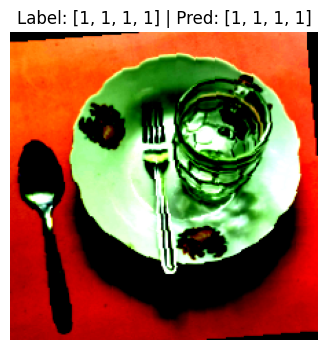

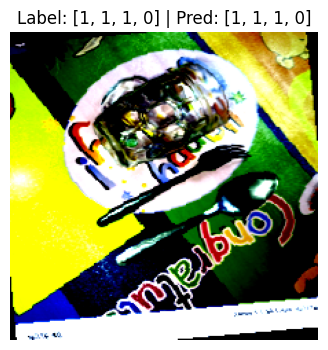

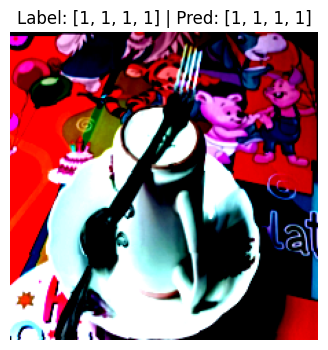

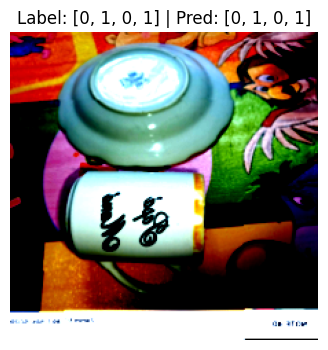

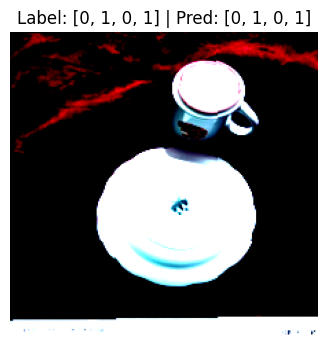

Sanity Check Setelah Training (Validation Loader):


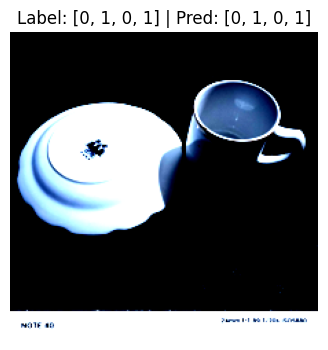

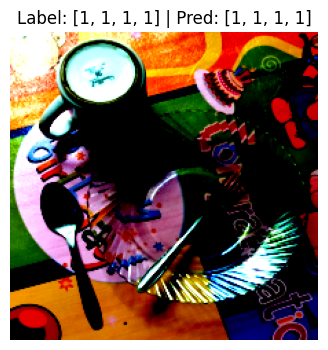

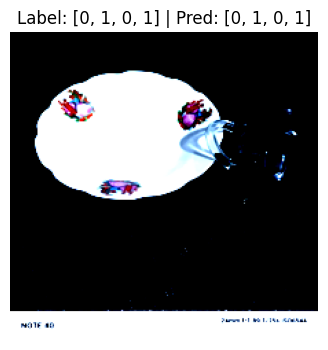

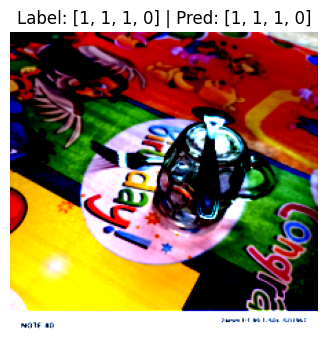

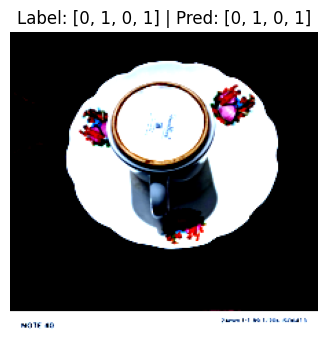

In [11]:
import matplotlib.pyplot as plt
import torch

def sanity_check_after_training(model, dataloader, class_names, device, n_samples=5):
    model.eval()  # masuk mode evaluasi
    images_shown = 0

    with torch.no_grad():  # tidak perlu hitung gradien
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.sigmoid(outputs) > 0.5  # threshold multilabel

            for i in range(inputs.size(0)):
                img = inputs[i].cpu().permute(1, 2, 0).numpy()
                true_labels = labels[i].cpu().int().tolist()
                pred_labels = preds[i].cpu().int().tolist()

                # Buat tampilan gambar
                plt.figure(figsize=(4, 4))
                plt.imshow(img)
                plt.title(f"Label: {true_labels} | Pred: {pred_labels}")
                plt.axis("off")
                plt.show()

                images_shown += 1
                if images_shown >= n_samples:
                    return  # berhenti setelah n_samples

print("Sanity Check Setelah Training (Train Loader):")
sanity_check_after_training(model, train_loader, class_names, device)

print("Sanity Check Setelah Training (Validation Loader):")
sanity_check_after_training(model, val_loader, class_names, device)

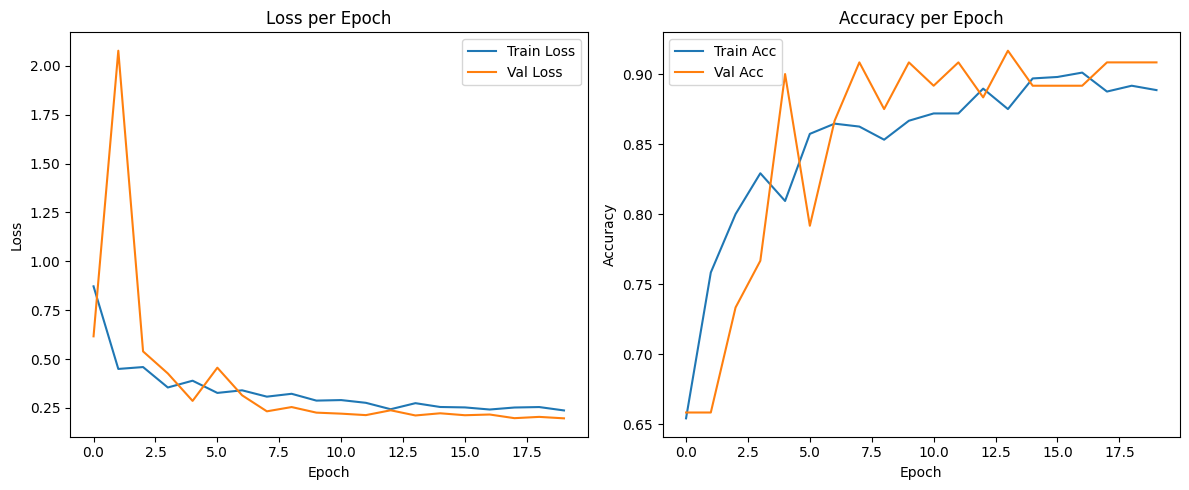

In [12]:
# ✅ 9. Plot Kurva
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()



In [13]:
# ✅ 10. Evaluasi di Test Set
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images).cpu()
        preds = (torch.sigmoid(outputs) > 0.5).int()
        all_preds.append(preds)
        all_labels.append(labels)

y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_labels).numpy()

print(classification_report(y_true, y_pred, target_names=class_names))

for i in range(len(class_names)):
    print(f"\nConfusion Matrix for class '{class_names[i]}':\n{multilabel_confusion_matrix(y_true, y_pred)[i]}")



              precision    recall  f1-score   support

      sendok       0.83      0.95      0.89        21
       gelas       1.00      1.00      1.00        30
       garpu       0.83      0.95      0.89        21
      piring       0.89      0.73      0.80        22

   micro avg       0.90      0.91      0.91        94
   macro avg       0.89      0.91      0.89        94
weighted avg       0.90      0.91      0.90        94
 samples avg       0.91      0.92      0.90        94


Confusion Matrix for class ' sendok':
[[ 5  4]
 [ 1 20]]

Confusion Matrix for class ' gelas':
[[ 0  0]
 [ 0 30]]

Confusion Matrix for class ' garpu':
[[ 5  4]
 [ 1 20]]

Confusion Matrix for class ' piring':
[[ 6  2]
 [ 6 16]]


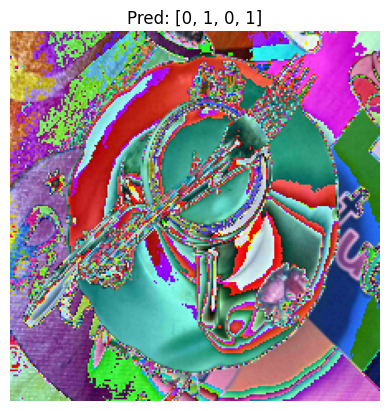

In [14]:
for img, lbl in test_dataset:
    plt.imshow(transforms.ToPILImage()(img))
    with torch.no_grad():
        output = model(img.unsqueeze(0).to(device))
        pred = (torch.sigmoid(output) > 0.5).int().squeeze().cpu().tolist()
    plt.title(f"Pred: {pred}")
    plt.axis('off')
    plt.show()
    break